In [ ]:
!pip -q install transformers

     |████████████████████████████████| 1.3MB 14.4MB/s 
     |████████████████████████████████| 1.1MB 49.7MB/s 
     |████████████████████████████████| 890kB 60.4MB/s 
     |████████████████████████████████| 2.9MB 53.1MB/s 


In [ ]:
import torch
import numpy as np
import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertModel
from torch.nn import CrossEntropyLoss
import re

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)
dev = torch.device(dev)

cuda:0


In [ ]:
## Possible Tags
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']
idx = 0
tag_to_idx = {}
for i in tag_vals:
  tag_to_idx[i] = idx
  idx += 1

print(tag_to_idx)

## Data files
train_path = 'train.txt'
test_path = 'test.txt'

idx = 0

def get_data(path):
  f = open(path, 'r')
  data = []
  labels = []
  words = []
  m1 = -1
  for line in f:
    line = line.split('###')
    data.append(line[0])
    tags = []
    line[1] = line[1].split()
    m1 = max(m1,len(line[1]))
    w = []
    for word in line[1]:
      word = [word[:word.find('=')+1], word[len(word) - word[::-1].find('='):]]
      w.append(word[0])
      try:
        tags.append(tag_to_idx[word[1]])
      except:
        print(word)
    labels.append(tags)
    words.append(w)
  return data, labels, words

train_data, train_labels, w1 = get_data(train_path)
test_data, test_labels, w2 = get_data(test_path)

{'O': 0, 'B-POS': 1, 'B-NEU': 2, 'B-NEG': 3, 'B-CON': 4, 'I-POS': 5, 'I-NEU': 6, 'I-NEG': 7, 'I-CON': 8, 'PAD': 9}


In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
    
comment_words = '' 
stopwords = set(STOPWORDS) 

total_sentences = train_data + test_data
for sent in total_sentences: 
    sent = sent.lower()
    tokens = sent.split() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 1).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  

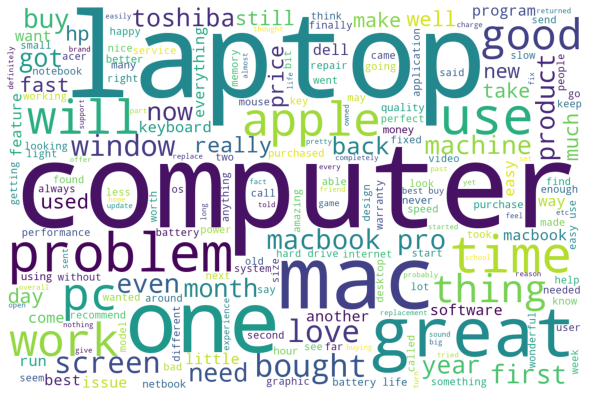

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
    
comment_words = '' 
stopwords = set(STOPWORDS) 

total_sentences = train_data + test_data
for sent in total_sentences: 
    sent = sent.lower()
    tokens = sent.split() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 1).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  

In [ ]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
lr = 1e-5
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class dataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, words,max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.words = words
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        word = self.words[index]
        label = self.labels[index]
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        label.extend([9]*200)
        label=label[:MAX_LEN]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
train_sentences = train_data
test_sentences = test_data
training_set = dataset(tokenizer, train_sentences, train_labels, w1,MAX_LEN)
testing_set = dataset(tokenizer, test_sentences, test_labels, w2, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']
labels_ = {}
for ex in train_labels:
  for t in ex:
    if tag_vals[t] in labels_:
      labels_[tag_vals[t]] += 1
    else:
      labels_[tag_vals[t]] = 1
print(labels_)
weights = [1/labels_['O'], 1/labels_['B-POS'], 1/labels_['B-NEU'], 1/labels_['B-NEG'], 1/labels_['B-CON'], 1/labels_['I-POS'], 1/labels_['I-NEU'], 1/labels_['I-NEG'], 1/labels_['I-CON'], 0.0001]

{'O': 47740, 'B-NEU': 451, 'B-POS': 982, 'I-POS': 364, 'I-NEU': 290, 'B-NEG': 858, 'I-NEG': 434, 'B-CON': 41, 'I-CON': 19}


In [ ]:
class BERT_with_self_attention(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERT_with_self_attention, self).__init__()
        self.num_labels = num_labels
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.multihead_attn = torch.nn.MultiheadAttention(768, 8)
        self.q = torch.nn.Linear(768, 768)
        self.k = torch.nn.Linear(768, 768)
        self.v = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, self.num_labels)
        self.act = torch.nn.ReLU()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        query = self.q(sequence_output)
        query = self.act(query)
        
        key = self.k(sequence_output)
        key = self.act(key)

        value = self.v(sequence_output)
        value = self.act(value)

        attn_output, attn_output_weights = self.multihead_attn(query, key, value)        
        logits = self.classifier(attn_output)

        loss = None
        global class_weights
        if labels is not None:
            class_weights = torch.FloatTensor(weights).cuda()
            loss_fct = CrossEntropyLoss(weight=class_weights)
            loss_fct = CrossEntropyLoss()

            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        output = (logits,) + outputs[2:]
        return ((loss,) + output) if loss is not None else output

In [ ]:
model = BERT_with_self_attention(10)
model.to(dev)

BERT_with_self_attention(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
lr = 3e-5
optimizer = transformers.AdamW(params =  model.parameters(), lr=lr)

In [ ]:
lo = {}
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(dev, dtype = torch.long)
        mask = data['mask'].to(dev, dtype = torch.long)
        targets = data['tags'].to(dev, dtype = torch.long)
        loss = model(ids, mask, labels = targets)[0]
        if _%500==0:
            lo[epoch] = loss.item()
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  2.2685282230377197
Epoch: 1, Loss:  0.7288472056388855
Epoch: 2, Loss:  0.4496418833732605
Epoch: 3, Loss:  0.39407455921173096
Epoch: 4, Loss:  0.3486642837524414
Epoch: 5, Loss:  0.3609139621257782
Epoch: 6, Loss:  0.3479499816894531
Epoch: 7, Loss:  0.34470176696777344
Epoch: 8, Loss:  0.3416174054145813
Epoch: 9, Loss:  0.31132858991622925
Epoch: 10, Loss:  0.24316129088401794
Epoch: 11, Loss:  0.19554005563259125
Epoch: 12, Loss:  0.2157023847103119
Epoch: 13, Loss:  0.20059630274772644
Epoch: 14, Loss:  0.1490934193134308
Epoch: 15, Loss:  0.1286444365978241
Epoch: 16, Loss:  0.1232258751988411
Epoch: 17, Loss:  0.1254662722349167
Epoch: 18, Loss:  0.11511362344026566
Epoch: 19, Loss:  0.09361401945352554


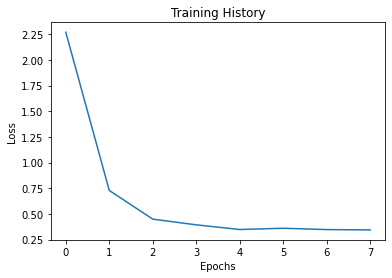

In [ ]:
ep = [i for i in range(8)]
loss = []
for i in range(8):
  loss.append(lo[i])

plt.plot(ep, loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training History')
plt.show()

In [ ]:
def valid(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.append([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            eval_loss += loss.mean().item()
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        return predictions, true_labels

In [ ]:
p,t = valid(model, testing_loader)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
y_true = []
y_pred = []
for batch in range(len(t)):
  for entry in range(len(t[batch])):
    N = 0
    while t[batch][entry][N] != 9 and N<len(p[batch][entry]) and N<len(t[batch][entry]):
      N+=1 
    try:
      a = [tag_vals[p[batch][entry][i]] for i in range(N)]
      y_pred.append(a)
      b = [tag_vals[t[batch][entry][i]] for i in range(N)]
      y_true.append(b)
    except:
      print("Error")

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    if y_pred[i][j] == 'PAD':
      y_pred[i][j] = 'O'
    if y_true[i][j] == 'PAD':
      print(y_true[i])
      break

from sklearn import metrics
yp = [tag for sent in y_pred for tag in sent]
yt = [tag for sent in y_true for tag in sent]

In [ ]:
print(metrics.classification_report(yt, yp))

              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00        16
       B-NEG       0.17      0.23      0.20       125
       B-NEU       0.21      0.06      0.09       161
       B-POS       0.46      0.69      0.56       334
       I-CON       0.00      0.00      0.00         5
       I-NEG       0.21      0.38      0.27        79
       I-NEU       0.29      0.05      0.08       149
       I-POS       0.50      0.30      0.38       153
           O       0.98      0.98      0.98     10778

    accuracy                           0.93     11800
   macro avg       0.31      0.30      0.28     11800
weighted avg       0.92      0.93      0.92     11800



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(yt, yp))
confusion_matrix.columns = ['B-CON', 'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O']
confusion_matrix.index = ['B-CON', 'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O']
print(confusion_matrix)

ValueError: ignored

In [ ]:
PATH = 'absa_lapt_self_attn.sav'
## Save
torch.save(model.state_dict(), PATH)

In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


sent = {'NEG':'Negative', 'POS': 'Positive', 'NEU':'Neutral'}
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']

idx = 0
sentence = 'This Laptop is terrible! i dont like it'

sentence = sentence.lower()
inputs = tokenizer(sentence, return_tensors="pt", max_length= 100 ,padding='max_length')
id = inputs['input_ids'].to(dev)
ret = tokenizer.decode(id[0])
att = inputs['attention_mask'].to(dev)
output = model(id, att)
logits = output[0]
logits = logits.detach().cpu().numpy()
a = [list(p) for p in np.argmax(logits, axis=2)]
out = a[0]
out = [tag_vals[i] for i in out]

asp = []
inpu = word_tokenize(sentence)
out = out[:len(inpu)]
i = 0
while i< len(out):
  if out[i] != 'O' and out[i] !='PAD':
    j = i
    aspect_term = [inpu[j]]
    j+=1
    while j<len(out) and out[j] == 'I-'+out[i][2:]:
      aspect_term.append(inpu[j]) 
      j+=1
    aspect_term = ' '.join(aspect_term)
    asp.append((aspect_term,out[i][2:]))
    i = j
  else:
    i+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print('Input Sentence:',sentence)
if len(asp) == 0:
  print("No Aspect Terms")
else:
  for entry in asp:
    print('Aspect Term: {}, Sentiment: {}'.format(entry[0], sent[entry[1]]))

Input Sentence: this laptop is terrible! i dont like it
No Aspect Terms
